In [4]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [11]:
# Import Data
adata = sc.read_h5ad('/home/glennrdx/Documents/Research_Project/processed_h5ad/crypt_enriched_temp.h5ad')

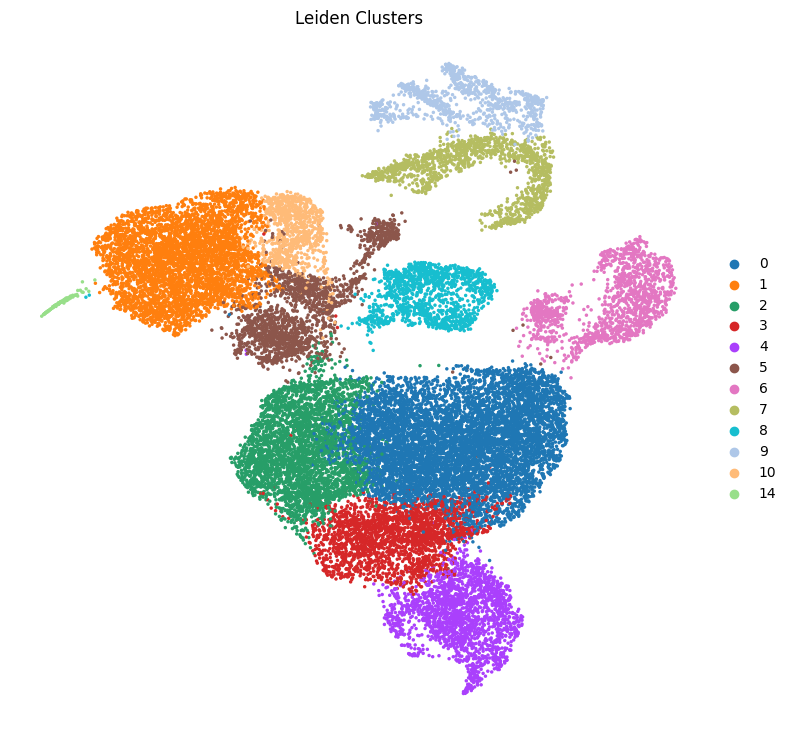

In [12]:
# Plot the UMAP
fig, ax = plt.subplots(figsize=(9, 9))  # Adjust the figsize values as needed

# Plot UMAP on the specified axis
sc.pl.umap(
    adata,
    color=["leiden"],
    frameon=False,
    size=25,
    ax=ax,
    title = 'Leiden Clusters'
)

# Show the plot
plt.show()

## Functions to help with annotation

In [29]:
def combine_clusters(adata, annotation_name, clusters_to_combine):
    """
    Combine specified clusters into one cluster in the given AnnData object and display before and after UMAPs.

    Parameters:
    -----------
    adata : AnnData
        The AnnData object containing the single-cell data.
    annotation_name : str
        The name of the annotation column in adata.obs to be modified.
    clusters_to_combine : list
        List of cluster names to be combined.

    Returns:
    --------
    None. The function modifies the adata object in-place and displays UMAPs.
    """
    # Create a new annotation column
    new_annotation_name = f"{annotation_name}1"
    adata.obs[new_annotation_name] = adata.obs[annotation_name].copy()

    # Print the new annotation name
    print(f"New annotation name: {new_annotation_name}")

    # Plot the UMAP before combining clusters
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    sc.pl.umap(adata, color=[annotation_name], ax=ax1, show=False, title='Before combining clusters', size = 20)

    # Set the target label as the first cluster in the list
    target_label = clusters_to_combine[0]

    # Extract the current cluster labels
    cluster_labels = adata.obs[new_annotation_name]

    # Update cluster labels for the specified clusters
    adata.obs[new_annotation_name] = cluster_labels.apply(lambda x: target_label if x in clusters_to_combine else x)

    # Plot the UMAP after combining clusters
    sc.pl.umap(adata, color=[new_annotation_name], ax=ax2, show=False, title='After combining clusters', size = 20)

    plt.tight_layout()
    plt.show()

# Example usage:
# clusters_to_combine = [
#     'EE progenitor,3', 'EE progenitor,6', 'EE progenitor,4',
#     'EE progenitor,5', 'EE progenitor,11', 'EE progenitor,10',
#     'EE progenitor,9', 'EE progenitor,8', 'EE progenitor,7'
# ]
# combine_clusters(adata, 'final_annotations', clusters_to_combine)

In [53]:
def recluster_subset(adata, annotation_name, cluster_name, new_annotation_name, resolution):
    """
    Recluster a specific subset of cells using Leiden algorithm.

    Parameters:
    -----------
    adata : AnnData
        The AnnData object containing the single-cell data.
    annotation_name : str
        The name of the annotation column to use for subsetting.
    cluster_name : str
        The name of the cluster to recluster.
    new_annotation_name : str
        The name of the new annotation column to store the results.
    resolution : float
        The resolution parameter for the Leiden algorithm.

    Returns:
    --------
    None. The function modifies the adata object in-place.
    """
        # Plot the UMAP before reclustering
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    sc.pl.umap(adata, color=[annotation_name], ax=ax1, show=False, title='Before Reclustering - ' + annotation_name, size = 20)

    sc.tl.leiden(adata, restrict_to=(annotation_name, [cluster_name]), 
                 key_added=new_annotation_name, resolution=resolution, random_state=1)
    
    # Plot the UMAP after reclustering
    sc.pl.umap(adata, color=[new_annotation_name], ax=ax2, show=False, title='After Reclustering - ' + new_annotation_name, size = 20)
    
    plt.tight_layout()
    plt.show()

# Example usage:
# recluster_subset(adata, 'EEC_refined_final', 'EE progenitor', 'final_annotations', 0.2)

In [50]:
def plot_gene_heatmap_umap(adata, genes, size = 20):
    """
    Plot heatmap UMAPs for a list of genes in an AnnData object.

    Parameters:
    -----------
    adata : AnnData
        The AnnData object containing the single-cell data.
    genes : list
        A list of gene names to plot.

    Returns:
    --------
    None. The function displays the plots.
    """
    num_genes = len(genes)
    fig, axes = plt.subplots(1, num_genes, figsize=(6*num_genes, 6))
    
    if num_genes == 1:
        axes = [axes]
    
    for ax, gene in zip(axes, genes):
        sc.pl.umap(
            adata,
            color=gene,
            title=f'UMAP Heatmap - {gene}',
            frameon=False,
            ax=ax,
            size=size,
            color_map='viridis',
            show=False
        )
        
        ax.set_facecolor('black')
    
    plt.tight_layout()
    plt.show()

# Example usage:
# plot_gene_heatmap_umap(adata, ['Gene1', 'Gene2', 'Gene3'])

In [57]:
def plot_combined_gene_heatmap_umap(adata, genes, size=20):
    """
    Plot a combined heatmap UMAP for a list of genes in an AnnData object.

    Parameters:
    -----------
    adata : AnnData
        The AnnData object containing the single-cell data.
    genes : list
        A list of gene names to plot.
    size : int, optional
        Size of the points in the plot. Default is 20.

    Returns:
    --------
    None. The function displays the plot.
    """
    # Create a new AnnData object with only the specified genes
    adata_subset = adata[:, genes].copy()
    
    # Normalize the expression values for each gene
    sc.pp.scale(adata_subset)
    
    # Calculate the average expression across all genes
    adata_subset.obs['combined_expression'] = adata_subset.X.mean(axis=1)
    
    # Plot the combined heatmap
    fig, ax = plt.subplots(figsize=(6, 6))
    sc.pl.umap(
        adata_subset,
        color='combined_expression',
        title='Combined Gene Expression Heatmap',
        frameon=False,
        ax=ax,
        size=size,
        color_map='viridis',
        show=False
    )
    
    ax.set_facecolor('black')
    
    # Add gene names to the plot legend
    ax.text(1.05, 1, ', '.join(genes), transform=ax.transAxes, va='top', ha='left', fontsize=10, wrap=True)
    
    plt.tight_layout()
    plt.show()

# Example usage:
# plot_combined_gene_heatmap_umap(adata, ['Gene1', 'Gene2', 'Gene3'])

In [ ]:
def divide_cluster_by_expression(adata, genes, cluster_name, annotation, x=0.2):
    """
    Divide a specified cluster into two groups based on the combined expression of a list of genes.

    Parameters:
    -----------
    adata : AnnData
        The AnnData object containing the single-cell data.
    genes : list
        A list of gene names to calculate combined expression.
    cluster_name : str
        The name of the cluster to divide.
    annotation : str, optional
        The name of the annotation column in `adata.obs` to use for cluster identification. Default is 'leiden1'.
    x : float, optional
        The top portion of expressors to include in the first group (e.g., 0.2 for top 20%). Default is 0.2.

    Returns:
    --------
    adata : AnnData
        The modified AnnData object with the new group information in `obs['cluster_name_divided']`.
    """
    # Create a new AnnData object with only the specified genes
    adata_subset = adata[:, genes].copy()

    # Normalize the expression values for each gene
    sc.pp.scale(adata_subset)

    # Calculate the average expression across all genes
    adata_subset.obs['combined_expression'] = adata_subset.X.mean(axis=1)
    
    # Identify the cells in the specified cluster using the provided annotation
    cluster_mask = adata.obs[adata.obs[annotation] == cluster_name].index

    # Subset to cells within the specified cluster
    cluster_subset = adata_subset[cluster_mask].copy()

    # Determine the threshold for top x% expressors
    threshold = cluster_subset.obs['combined_expression'].quantile(1 - x)
    
    # Create a new column to indicate the group
    adata.obs[f'{cluster_name}_divided'] = 'Low'
    adata.obs.loc[cluster_subset.obs['combined_expression'] >= threshold, f'{cluster_name}_divided'] = 'High'
    
    return adata

# Example usage:
# adata = divide_cluster_by_expression(adata, ['Gene1', 'Gene2', 'Gene3'], '0', annotation='leiden1', x=0.2)


In [61]:
# Marker Gene Dictionary
marker_dict = {'ISC': ['Lgr5', 'Olfm4', 'Axin2', 'Ascl2', 'Slc12a2'],
               'Enterocyte': ['Fabp1', 'Alpi', 'Apoa1', 'Apoa4', 'Lct'],
               'Goblet': ['Muc2', 'Tff3', 'Agr2', 'Spdef', 'Klf4', 'Tff3', 'Ccl9', 'Manf'],
               'Goblet progenitor': ['Spdef', 'Atoh1'],
               'Paneth': ['Lyz1', 'Mmp7', 'Defa17', 'Defa22', 'Ang4'],
               'EEC': ['Neurod1', 'Neurod2', 'Insm1', 'Chga', 'Chgb'],
               'EE progenitor': ['Sox4', 'Neurog3', 'Foxa2', 'Foxa3', 'Marcksl1'],
               'Tuft': ['Dclk1', 'Trpm5', 'Gfi1b', 'Il25'],
               'Lymphocyte': ['Coro1a', 'Cd52', 'Cd37']
               }

## Annotation

New annotation name: leiden1


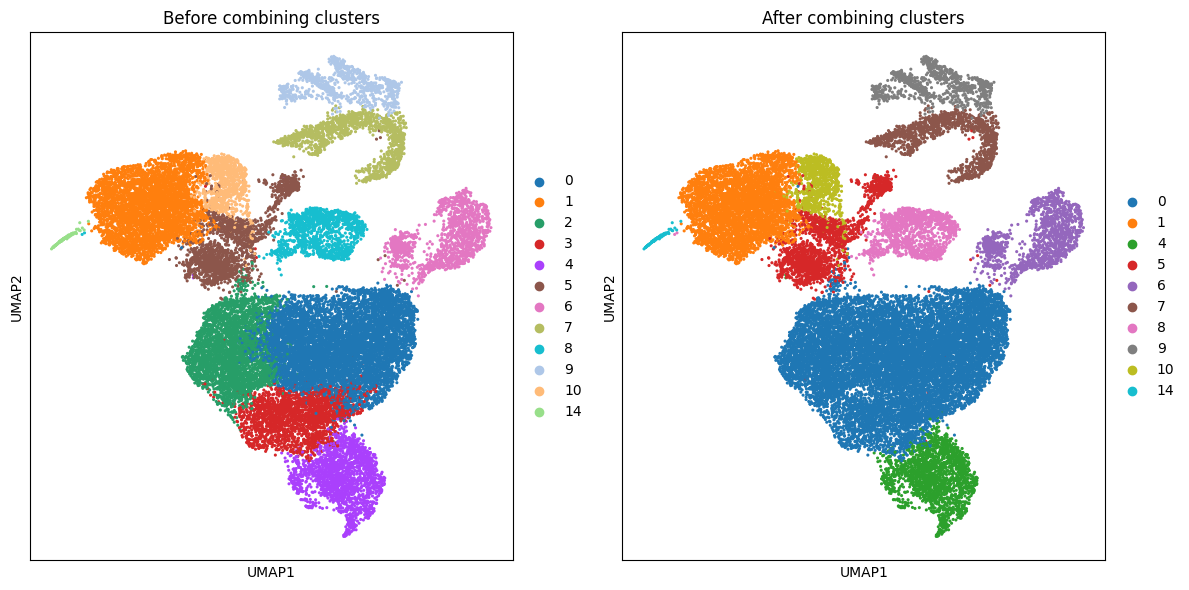

In [34]:
clusters_to_combine = ['0','2','3']
combine_clusters(adata, 'leiden', clusters_to_combine)

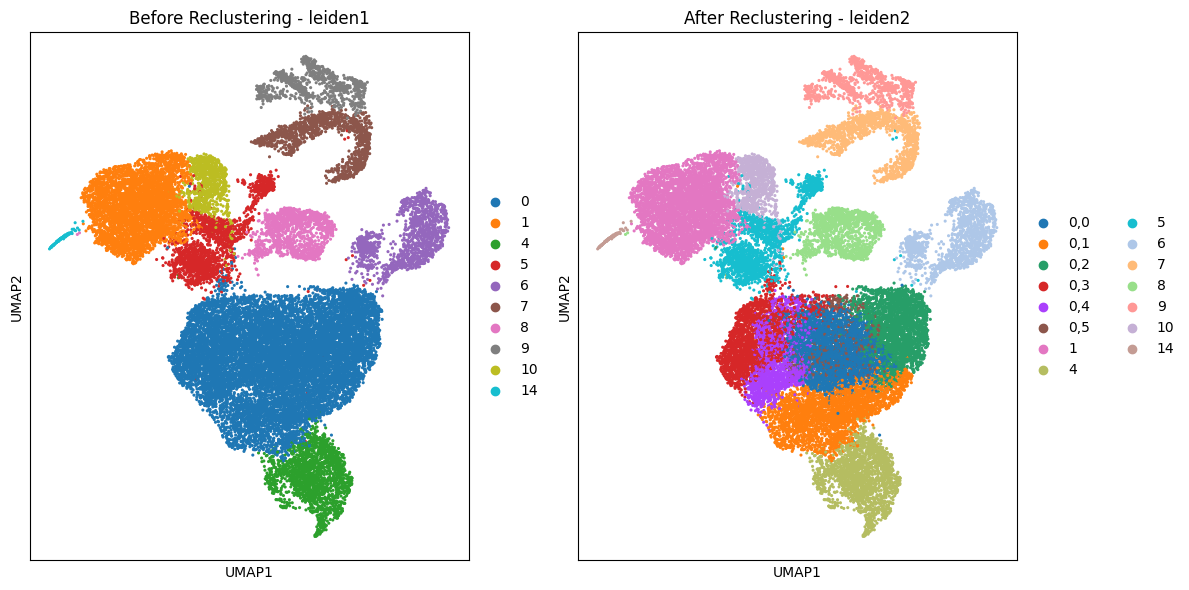

In [54]:
recluster_subset(adata, 'leiden1', '0', 'leiden2', 0.3)

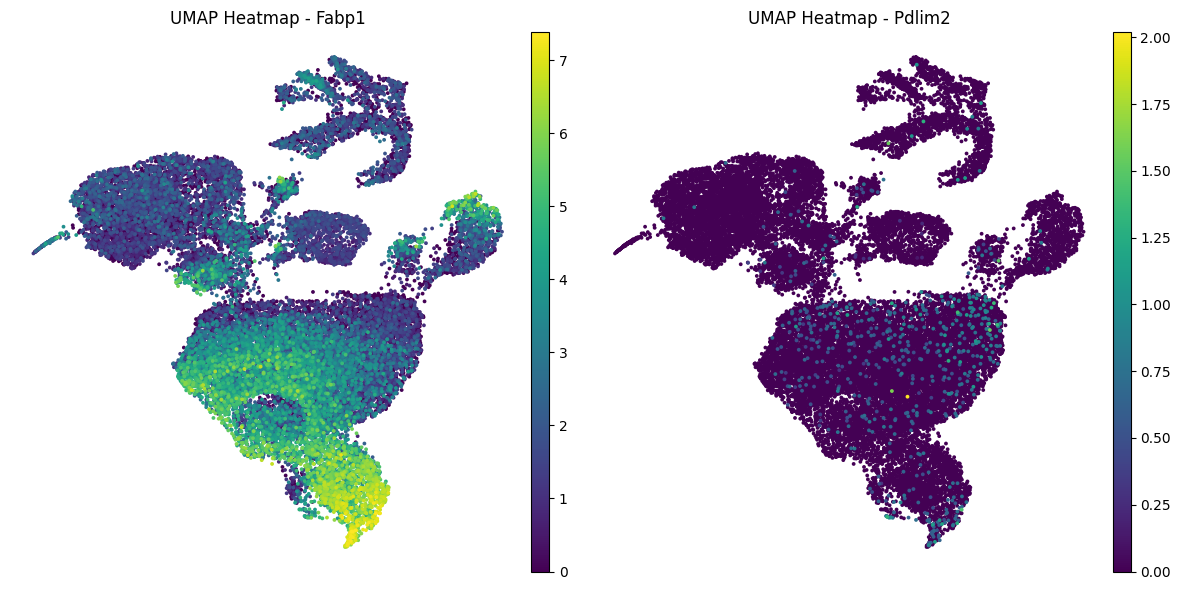

In [76]:
plot_gene_heatmap_umap(adata, ['Fabp1', 'Pdlim2'], size = 30)

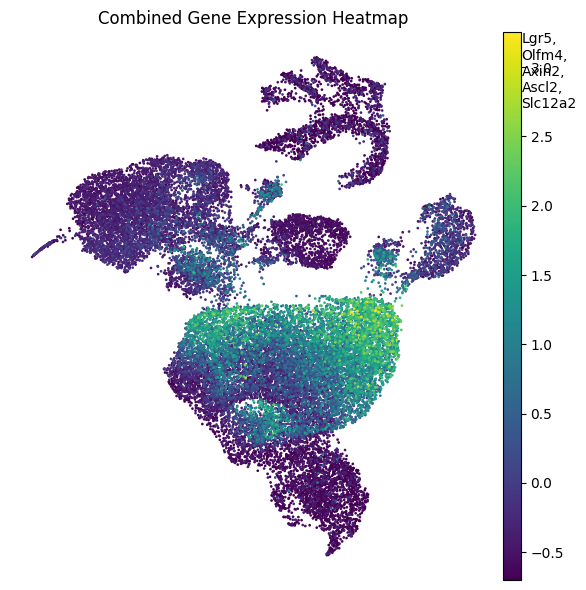

In [74]:
plot_combined_gene_heatmap_umap(adata, marker_dict['ISC'], size = 15)

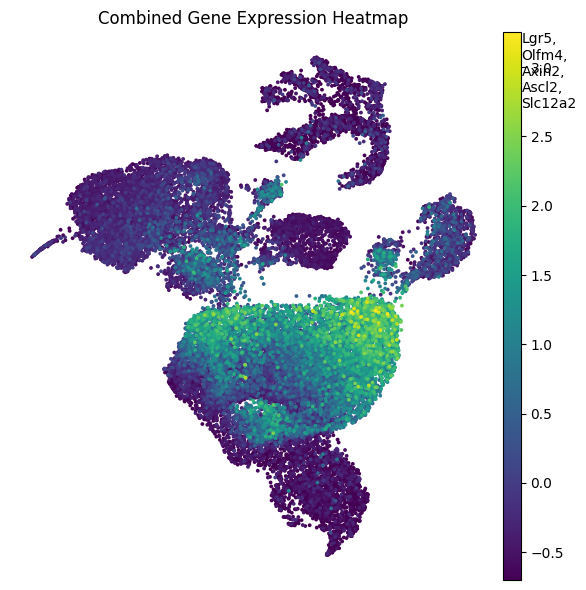

In [77]:
plot_combined_gene_heatmap_umap(adata, marker_dict['ISC'], size = 30)